# CSE253 PA3 - Simplicity All-CNN (Part Deux)
With a simple 5-layer CNN, we achieved up to 87% validation accuracy, 83% test accuracy and ensemble test accuracy of 87%.

We decide to improve on this by following the general direction proposed by "Strive for Simplicity":

https://arxiv.org/abs/1412.6806

The general idea is that an all-CNN network can equal or outperform current state-of-the-art CNNs by:

1. Replace maxpool layer with a convolutional layer of stride=2
2. The linear layer can be replaced with a "network-in-network" structure

We discover that replacing maxpooling with a convolutional layer (stride=2) achieve the same 2:1 downsampling while increasing the learning ability of the CNN. We achieve 89.6% validation accuracy, 87.2% single model test accuracy and 90.2% ensemble test accuracy. We also discover that average pooling degrade CNN performance, so we keep the fully connected Linear Layer before Softmax.

In this second Notebook, we will take out the 2nd maxpool and see what further improvement the model can achieve.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T

from torchviz import make_dot, make_dot_from_trace

import numpy as np
import timeit
import time
import platform
import random
import pickle as pickle
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

Python version:  3.6.3


In [89]:
import torchvision.transforms as transforms

class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 48000
NUM_VAL = 1000
NUM_TRAIN_SMALL=2000

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([
    # transforms.RandomResizedCrop(32),  # data augmentation - random crop
    transforms.RandomHorizontalFlip(),      # data augmentation - horizontal flip
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0))
loader_train_small = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN_SMALL, 0))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True, 
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
                          transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64, shuffle= False)

# PyTorch way of loading CFAR-10
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [2]:
cpu_dtype = torch.FloatTensor # the CPU datatype
gpu_dtype = torch.cuda.FloatTensor

# Constant to control how frequently we print train loss
print_every = 100

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
        
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

Size of CFAR10 Train Set:  50000
torch.Size([64, 3, 32, 32])
 frog truck truck  deer   car   car  bird horse  ship   cat  deer horse horse  bird truck truck truck   cat  bird  frog  deer   cat  frog  frog  bird  frog   cat   dog  deer plane plane truck   car   cat  deer plane   cat horse   cat   cat   dog  bird  bird horse   car   car   car  bird  bird plane truck   dog horse truck  bird  bird   dog  bird  deer   cat   car   car  ship  bird


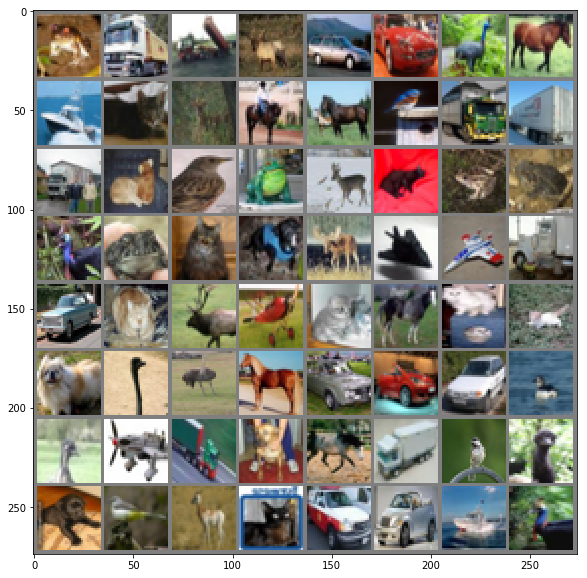

In [4]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

print ("Size of CFAR10 Train Set: ", len(cifar10_train))
    
# get some random training images
dataiter = iter(loader_train)
images, labels = dataiter.next()

print (images.size())

# show images
plt.figure(figsize=(10,10))
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(64)))

In [5]:
def train_simple(model, loss_fn, optimizer, num_epochs = 10, verbose=False):
    # Train the model - output validation and train accuracy every epoch
    
    train_history = []   # this will store train accuracy, val accuracy and loss for every epoch

    scheduler = StepLR(optimizer, step_size=5, gamma=0.9)   # decay lr by 0.9 every 5 epochs 
    # scheduler = StepLR(optimizer, step_size=1, gamma=0.95)   # decay lr by 0.95 every epoch 
    
    for epoch in range(num_epochs):        
        
        scheduler.step()    
        model.train()
        
        train_lossSum = 0 
        train_total = 0
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            train_total += y_var.size(0)

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            train_lossSum += loss.data[0]  # Accumulate loss over epoch
            
            if (t + 1) % print_every == 0 and verbose:
                print('t = %d, loss = %.6f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
       
        # We calculate validation and training accuracy at the end of every epoch
        val_acc = check_accuracy(model, loader_val) 
        train_acc = check_accuracy(model, loader_train_small)
       
        if verbose:
            print("epoch {}/{}: train acc={:.3f}, val acc={:.3f}, loss={:.8f}".format(epoch + 1, \
                                        num_epochs, train_acc,val_acc,train_lossSum/train_total))
        train_history.append([train_acc,val_acc,train_lossSum/train_total])
        
    return train_history 


def train_detailed(model, loss_fn, optimizer, filename, num_epochs = 10, verbose=False):
    # Train the model in greater detail - output validation and train accuracy every epoch
    
    train_history = []   # this will store train accuracy, val accuracy and loss for every epoch
    best_val_acc = 0.0  # initialize best_val_acc

    scheduler = StepLR(optimizer, step_size=5, gamma=0.9)   # decay lr by 0.9 very 5 epochs 
    # scheduler = StepLR(optimizer, step_size=1, gamma=0.95)   # decay lr by 0.95 every epoch 
    
    for epoch in range(num_epochs):        
        
        scheduler.step()    
        model.train()
        
        train_lossSum = 0 
        train_total = 0
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            train_total += y_var.size(0)

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            train_lossSum += loss.data[0]  # Accumulate loss over epoch
            
            if (t + 1) % print_every == 0 and verbose:
                print('t = %d, loss = %.6f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
       
        # We calculate validation and training accuracy at the end of every epoch
        val_acc = check_accuracy(model, loader_val) 
        train_acc = check_accuracy(model, loader_train_small)

        # Compute validation loss    
        val_lossSum = 0.0
        val_total = 0
        for t, (x, y) in enumerate(loader_val):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            val_total += y_var.size(0)
            
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            val_lossSum += loss.data[0]
        
        if val_acc > best_val_acc:  
            # save your model
            if verbose:
                print ("better val accuracy: update model.")
            torch.save(model.state_dict(), filename)
            best_val_acc = val_acc 

        if verbose:
            print("epoch {}/{}: train acc={:.3f}, val acc={:.3f}, train loss={:.8f}, val loss ={:.8f}". \
                  format(epoch + 1, num_epochs, train_acc,val_acc,train_lossSum/train_total, val_lossSum/val_total))
    
        train_history.append([train_acc,val_acc,train_lossSum/train_total,val_lossSum/val_total])
        
    return best_val_acc, train_history 
        

def check_accuracy(model, loader, verbose=False, dtype=gpu_dtype):
    if verbose:
        if loader.dataset.train:
            print('Checking accuracy on validation set')
        else:
            print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    if verbose:
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc


## Network Architecture Design



In [3]:
"""
def generator():

    # Model2 - Original Simple 5 layer Conv Layers

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half        
                    Flatten(),
                    nn.Linear(8192,512),  # 5408=128*16*16 input size
                    nn.BatchNorm1d(512),
                    nn.ReLU(inplace=True),
                    nn.Linear(512,10),
                    )
    
    
    return model  


def generator():

    # Model2a - 5 layer Conv Layers with average pooling

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half        

                    nn.AvgPool2d(8),
                    Flatten(),
                    nn.Linear(128,10),
                    )
    
    
    return model 


def generator_m31():

    # Model3-1 - 7 layer Conv Layers with average pooling, replace both maxpools with conv(stride=2)

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2,padding=1), # 2:1 downsample
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),        
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=2,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=512),        
                    nn.AvgPool2d(8),
                    Flatten(),
                    nn.Linear(512,10),
                    )
    return model 

def generator_m32():

    # Model3-2 - 6 layer Conv Layers with average pooling, replace 1 maxpool with conv(stride=2)

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2,padding=1), # 2:1 downsample
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),        
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half         
                    nn.AvgPool2d(8),
                    Flatten(),
                    nn.Linear(256,10),
                    )
    return model


def generator_m33():

    # Model3-3 - Wider 6 layer Conv Layers with average pooling, replace 1 maxpool with conv(stride=2)

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=2,padding=1), # 2:1 downsample
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),        
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half         
                    nn.AvgPool2d(8),
                    Flatten(),
                    nn.Linear(256,10),
                    )
    return model


def generator_m34():

    # Model3-4 - 6 layer Conv Layers - replace 1st maxpools with conv(stride=2)

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2,padding=1), # 2:1 downsample
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),        
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half        
                    Flatten(),
                    nn.Linear(16384,512),  # 16384=256*8*8 input size
                    nn.BatchNorm1d(512),
                    nn.ReLU(inplace=True),
                    nn.Linear(512,10)
                    )
    return model

def generator_m35():

    # Model3-5 - Wide 6 layer Conv Layers - replace 1st maxpools with conv(stride=2)

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=2,padding=1), # 2:1 downsample
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),        
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half      
                    Flatten(),
                    nn.Linear(16384,512),  # 16384=256*8*8 input size
                    nn.BatchNorm1d(512),
                    nn.ReLU(inplace=True),
                    nn.Linear(512,10)
                    )
    return model


def generator_m36():

    # Model3-6 - 10 layer Conv Layers - replace 1st maxpools with conv(stride=2), replace Maxpool-Linear 
    # with 3-layer "network-in-network"

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2,padding=1), # 2:1 downsample
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),        
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=2,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256) ,       
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),        
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=1,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=10,kernel_size=1,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=10),        
                    nn.AvgPool2d(10),       
                    Flatten()
                    )
    return model

def generator_m37():

    # Model3-7 - 9 layer Conv Layers - replace 1st maxpools with conv(stride=2), replace Maxpool-Linear 
    # with 3-layer "network-in-network"

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2,padding=1), # 2:1 downsample
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),        
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=2,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),        
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=1,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=10,kernel_size=1,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=10),        
                    nn.AvgPool2d(10),       
                    Flatten()
                    )
    return model
    
"""
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
def generator_m38():

    # Model3-8 - Wide 7 layer Conv Layers - replace both maxpools with conv(stride=2)

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=2,padding=1), # 2:1 downsample
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),        
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=2,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    Flatten(),
                    nn.Linear(16384,512),  # 16384=256*8*8 input size
                    nn.BatchNorm1d(512),
                    nn.ReLU(inplace=True),
                    nn.Linear(512,10)
                    )
    return model


### Dimension Check

Handy to check dimension when putting together a CNN architecture

In [7]:
generators = [generator_m38]

for generator in generators:
    model = generator().type(gpu_dtype)
    print (model)
    
    x_gpu = torch.randn(64, 3, 32, 32).type(gpu_dtype)
    x_var_gpu = Variable(x_gpu.type(gpu_dtype)) # Construct a PyTorch Variable out of your input data
    ans = model(x_var_gpu)        # Feed it through the model! 

    print (ans.shape)

    # Check to make sure what comes out of your model
    # is the right dimensionality... this should be True
    # if you've done everything correctly
    print (np.array_equal(np.array(ans.size()), np.array([64, 10])))

Sequential(
  (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (3): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace)
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (6): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): Conv2d (128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): ReLU(inplace)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (15): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU(inplace)
  (17): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (18): Conv2d (256, 256, kernel_s

### Coarse Accessment - Replace both Maxpool with Conv(Stride=2)

We want to evaluate the performance of an ALL-CONV CNN (no Maxpool) that retains the Linear Layer.

In [8]:
epochs = 3

generators = [generator_m38]

for generator in generators:
    print (generator())
    stat = []
    
    start = time.time()
    max_count = 20
    for count in range(max_count):
        reg = 1e-10
        lr = 10**random.uniform(-5,-2)
        
        model = generator().type(gpu_dtype)
    
        loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
        train_simple(model, loss_fn, optimizer, num_epochs=epochs)
        val_acc = check_accuracy(model, loader_val)
    
        print('lr = {:.5e}, reg = {:.5e}, validation accuracy is {:.8f}  '.format(lr, reg, val_acc))
        stat.append([lr, reg, val_acc])

    end = time.time()
    
    print('Training time per epochs: {:.2f} sec'.format((end-start)/(epochs*max_count)))

    sorted_stat = sorted(stat, key=lambda x: x[0], reverse=True)
    print ("In descending order of learning rate:")
    for lr, reg, val_acc in sorted_stat:
        print('lr = {:.5e}, reg = {:.5e}, validation accuracy is {:.8f}  '.format(lr, reg, val_acc)) 

Sequential(
  (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (3): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace)
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (6): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): Conv2d (128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): ReLU(inplace)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (15): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU(inplace)
  (17): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (18): Conv2d (256, 256, kernel_s

## Architecture Evaluation 

We need to equal or exceed the baseline of Model3-5:

### Wider 6-layer model - Replace MaxPool 
* Model3-5 - Wide 6 layer Conv Layers - replace 1st maxpools with conv(stride=2)
* Val Accuracy up to 83.1% (after training 3 epochs) ;16sec train time/epoch 

lr = 5.60940e-03, reg = 1.00000e-10, validation accuracy is 0.76300000  
lr = 3.16676e-03, reg = 1.00000e-10, validation accuracy is 0.78300000  
** lr = 2.75891e-03, reg = 1.00000e-10, validation accuracy is 0.80600000 **  
lr = 2.40521e-03, reg = 1.00000e-10, validation accuracy is 0.79700000  
** lr = 2.01972e-03, reg = 1.00000e-10, validation accuracy is 0.81000000 **  
** lr = 1.60149e-03, reg = 1.00000e-10, validation accuracy is 0.81300000 **  
** lr = 1.06442e-03, reg = 1.00000e-10, validation accuracy is 0.82000000 **  
** lr = 1.05233e-03, reg = 1.00000e-10, validation accuracy is 0.82500000 **  
** lr = 6.31104e-04, reg = 1.00000e-10, validation accuracy is 0.83100000 **  
** lr = 6.11237e-04, reg = 1.00000e-10, validation accuracy is 0.82600000 **  
** lr = 5.57130e-04, reg = 1.00000e-10, validation accuracy is 0.81900000 **  
** lr = 2.75476e-04, reg = 1.00000e-10, validation accuracy is 0.80900000 **  
lr = 9.68650e-05, reg = 1.00000e-10, validation accuracy is 0.73500000  
lr = 6.47994e-05, reg = 1.00000e-10, validation accuracy is 0.72200000  
lr = 5.98320e-05, reg = 1.00000e-10, validation accuracy is 0.72000000  
lr = 5.07041e-05, reg = 1.00000e-10, validation accuracy is 0.70600000  
lr = 4.42382e-05, reg = 1.00000e-10, validation accuracy is 0.69600000  
lr = 3.57490e-05, reg = 1.00000e-10, validation accuracy is 0.70100000  
lr = 2.61477e-05, reg = 1.00000e-10, validation accuracy is 0.69700000  
lr = 1.47912e-05, reg = 1.00000e-10, validation accuracy is 0.65400000    

Training time per epochs: 16.31 sec

### Wider 7-layer model - Replace Both MaxPool (More Accurate, Slower)
* Model3-8 - Wide 8 layer Conv Layers - replace both maxpools with conv(stride=2)

lr = 8.01115e-03, reg = 1.00000e-10, validation accuracy is 0.79100000  
lr = 7.66011e-03, reg = 1.00000e-10, validation accuracy is 0.79000000  
lr = 3.60167e-03, reg = 1.00000e-10, validation accuracy is 0.80000000  
** lr = 1.62155e-03, reg = 1.00000e-10, validation accuracy is 0.82000000   
lr = 1.09468e-03, reg = 1.00000e-10, validation accuracy is 0.81100000   
lr = 6.48375e-04, reg = 1.00000e-10, validation accuracy is 0.83600000   
lr = 4.23455e-04, reg = 1.00000e-10, validation accuracy is 0.82800000   
lr = 3.55172e-04, reg = 1.00000e-10, validation accuracy is 0.83900000   
lr = 3.32412e-04, reg = 1.00000e-10, validation accuracy is 0.82400000   
lr = 2.37931e-04, reg = 1.00000e-10, validation accuracy is 0.82200000   
lr = 1.59068e-04, reg = 1.00000e-10, validation accuracy is 0.81000000 **  
lr = 8.21419e-05, reg = 1.00000e-10, validation accuracy is 0.78200000  
lr = 5.41373e-05, reg = 1.00000e-10, validation accuracy is 0.76300000  
lr = 3.55011e-05, reg = 1.00000e-10, validation accuracy is 0.74100000  
lr = 3.04703e-05, reg = 1.00000e-10, validation accuracy is 0.74400000  
lr = 2.50091e-05, reg = 1.00000e-10, validation accuracy is 0.72800000  
lr = 2.28070e-05, reg = 1.00000e-10, validation accuracy is 0.71200000  
lr = 2.22185e-05, reg = 1.00000e-10, validation accuracy is 0.69900000  
lr = 2.15141e-05, reg = 1.00000e-10, validation accuracy is 0.69300000  
lr = 1.30488e-05, reg = 1.00000e-10, validation accuracy is 0.66900000

Training time per epochs: 18.08 sec  

## Hyperparameter Optimization

We decide to proceed with Model3-8:
* We retain the Linear layers before Softmax
* We replace both Maxpool with Conv(Stride=2)

The learning rate range that gives the best val accuracy is [1e-4, 2e-3]

We thus perform random search over permutations of learning rate and regularization. At 18 seconds per epoch, we can do 50 permutations of 3 epochs each in 45 minutes.

In [9]:
stat = []
epoch = 3

start = time.time()
max_count = 50

for count in range(max_count):
    reg = 10**random.uniform(-10,-3)
    lr = 10**random.uniform(-4,-2.5)
    
    model = generator_m38().type(gpu_dtype)
    
    loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    train_simple(model, loss_fn, optimizer, num_epochs=epochs)
    val_acc = check_accuracy(model, loader_val)
    
    print('lr = {:.5e}, reg = {:.5e}, validation accuracy is {:.8f}  '.format(lr, reg, val_acc))
    stat.append([lr, reg, val_acc])

end = time.time()
    
print('Training time per epochs: {:.2f} sec'.format((end-start)/(epochs*max_count)))

sorted_stat = sorted(stat, key=lambda x: x[0], reverse=True)
print ("In descending order of learning rate:")
for lr, reg, val_acc in sorted_stat:
    print('lr = {:.5e}, reg = {:.5e}, validation accuracy is {:.8f}  '.format(lr, reg, val_acc)) 

lr = 9.63709e-04, reg = 2.14917e-07, validation accuracy is 0.80500000  
lr = 5.53976e-04, reg = 8.45102e-10, validation accuracy is 0.82800000  
lr = 4.36876e-04, reg = 1.57841e-04, validation accuracy is 0.82400000  
lr = 1.73693e-03, reg = 6.48681e-05, validation accuracy is 0.78400000  
lr = 1.48886e-04, reg = 8.31427e-07, validation accuracy is 0.82200000  
lr = 3.00601e-03, reg = 4.33315e-07, validation accuracy is 0.78400000  
lr = 1.81914e-03, reg = 4.47045e-09, validation accuracy is 0.81700000  
lr = 1.70668e-03, reg = 3.22568e-07, validation accuracy is 0.82500000  
lr = 1.00697e-04, reg = 1.68876e-10, validation accuracy is 0.78600000  
lr = 8.38552e-04, reg = 1.27812e-08, validation accuracy is 0.81300000  
lr = 5.53937e-04, reg = 3.28456e-04, validation accuracy is 0.80900000  
lr = 1.15158e-04, reg = 2.10309e-06, validation accuracy is 0.78700000  
lr = 8.95680e-04, reg = 5.03912e-04, validation accuracy is 0.77800000  
lr = 1.59956e-03, reg = 1.73959e-07, validation acc

### Finetune Learning Rate + Regularization

* In descending order of learning rate:  
lr = 3.00601e-03, reg = 4.33315e-07, validation accuracy is 0.78400000  
lr = 2.38194e-03, reg = 1.81651e-06, validation accuracy is 0.78500000  
lr = 2.34857e-03, reg = 5.34578e-05, validation accuracy is 0.78400000  
lr = 2.19254e-03, reg = 8.36717e-10, validation accuracy is 0.80500000  
lr = 2.10706e-03, reg = 1.01161e-08, validation accuracy is 0.80700000  
lr = 1.96201e-03, reg = 1.06125e-07, validation accuracy is 0.79200000  
lr = 1.95657e-03, reg = 1.12314e-04, validation accuracy is 0.79600000  
** lr = 1.81914e-03, reg = 4.47045e-09, validation accuracy is 0.81700000 **  
lr = 1.73693e-03, reg = 6.48681e-05, validation accuracy is 0.78400000  
** lr = 1.70668e-03, reg = 3.22568e-07, validation accuracy is 0.82500000 **  
lr = 1.70657e-03, reg = 2.20241e-09, validation accuracy is 0.79300000  
lr = 1.67156e-03, reg = 3.19643e-04, validation accuracy is 0.74400000  
** lr = 1.59956e-03, reg = 1.73959e-07, validation accuracy is 0.81400000 **  
** lr = 1.40342e-03, reg = 2.98847e-08, validation accuracy is 0.82700000 **  
lr = 1.36305e-03, reg = 3.17594e-06, validation accuracy is 0.78900000  
** lr = 1.30902e-03, reg = 1.02970e-06, validation accuracy is 0.81700000 **  
lr = 1.19086e-03, reg = 3.22471e-06, validation accuracy is 0.81300000   
** lr = 1.11831e-03, reg = 1.91248e-08, validation accuracy is 0.82000000 **  
** lr = 1.02174e-03, reg = 1.08742e-10, validation accuracy is 0.82500000 **  
lr = 1.01826e-03, reg = 7.76977e-04, validation accuracy is 0.79500000  
lr = 1.01756e-03, reg = 4.07983e-05, validation accuracy is 0.81100000  
lr = 9.63709e-04, reg = 2.14917e-07, validation accuracy is 0.80500000  
lr = 8.95680e-04, reg = 5.03912e-04, validation accuracy is 0.77800000  
lr = 8.38552e-04, reg = 1.27812e-08, validation accuracy is 0.81300000  
** lr = 8.08232e-04, reg = 2.81757e-07, validation accuracy is 0.83600000  
lr = 6.85627e-04, reg = 1.19296e-07, validation accuracy is 0.82300000 **  
lr = 6.43440e-04, reg = 2.06155e-04, validation accuracy is 0.81500000  
lr = 6.27058e-04, reg = 1.32336e-07, validation accuracy is 0.80800000  
** lr = 5.53976e-04, reg = 8.45102e-10, validation accuracy is 0.82800000 **  
lr = 5.53937e-04, reg = 3.28456e-04, validation accuracy is 0.80900000  
** lr = 5.38335e-04, reg = 8.37981e-08, validation accuracy is 0.82900000  
lr = 5.10616e-04, reg = 4.46595e-07, validation accuracy is 0.82100000  
lr = 4.67030e-04, reg = 1.38274e-07, validation accuracy is 0.83000000  
lr = 4.58330e-04, reg = 2.21113e-08, validation accuracy is 0.82800000  
lr = 4.36876e-04, reg = 1.57841e-04, validation accuracy is 0.82400000  
lr = 3.59755e-04, reg = 1.29768e-08, validation accuracy is 0.82600000  
lr = 3.47849e-04, reg = 4.33435e-07, validation accuracy is 0.83800000  
lr = 2.48812e-04, reg = 2.61652e-04, validation accuracy is 0.82600000  
lr = 1.74974e-04, reg = 1.40907e-06, validation accuracy is 0.81200000  
lr = 1.68742e-04, reg = 4.99507e-10, validation accuracy is 0.81000000 **  
lr = 1.50914e-04, reg = 6.64964e-09, validation accuracy is 0.80100000  
** lr = 1.48886e-04, reg = 8.31427e-07, validation accuracy is 0.82200000 **  
lr = 1.48229e-04, reg = 1.65231e-05, validation accuracy is 0.81300000  
lr = 1.41605e-04, reg = 2.09654e-07, validation accuracy is 0.80600000  
lr = 1.37319e-04, reg = 3.47608e-04, validation accuracy is 0.80800000  
lr = 1.35621e-04, reg = 1.37022e-08, validation accuracy is 0.79400000  
lr = 1.15158e-04, reg = 2.10309e-06, validation accuracy is 0.78700000  
lr = 1.11518e-04, reg = 5.42294e-04, validation accuracy is 0.79600000  
lr = 1.04189e-04, reg = 7.46885e-09, validation accuracy is 0.77500000  
lr = 1.00697e-04, reg = 1.68876e-10, validation accuracy is 0.78600000  

## Fine Tuning with Long Training

At 18 seconds per epoch, a 60 epoch training will last 18 minutes. We can thus do 3 permutations per hour and about 50 permutations in 16 hours.

    reg = 10**random.uniform(-10,-4)
    lr = 10**random.uniform(-4,-2.5)
    
Some validation accuracy curves of Simplicity-I is still trending upward after 50 epochs, so we decide to up the number epochs per permutation to 60.

lr = 0.0006651496982526355, reg = 2.130299824755797e-06.
Best validation accuracy is 0.9. Training time for 60 epochs: 1073.94 sec


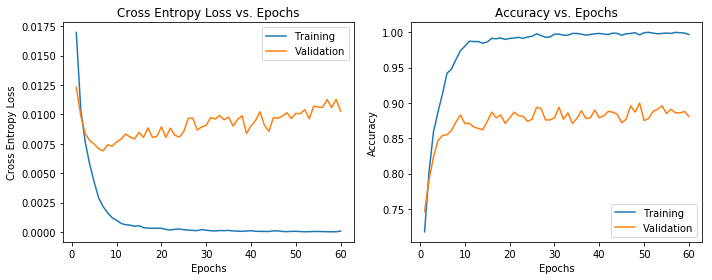

lr = 0.002590551968917525, reg = 6.218039415819107e-06.
Best validation accuracy is 0.884. Training time for 60 epochs: 1068.21 sec


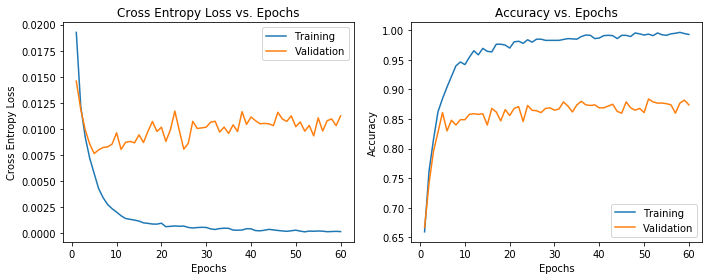

lr = 0.002382007347861838, reg = 4.862882962596396e-07.
Best validation accuracy is 0.883. Training time for 60 epochs: 1069.66 sec


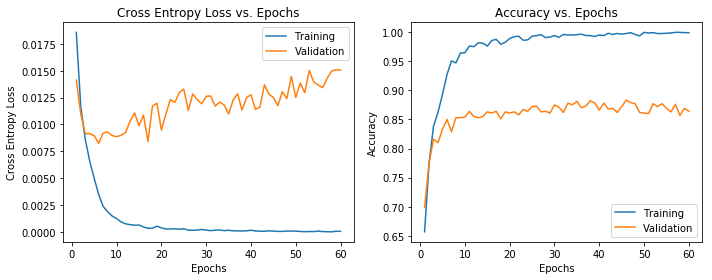

lr = 0.0014342707627145856, reg = 1.1114960630179666e-08.
Best validation accuracy is 0.895. Training time for 60 epochs: 1069.49 sec


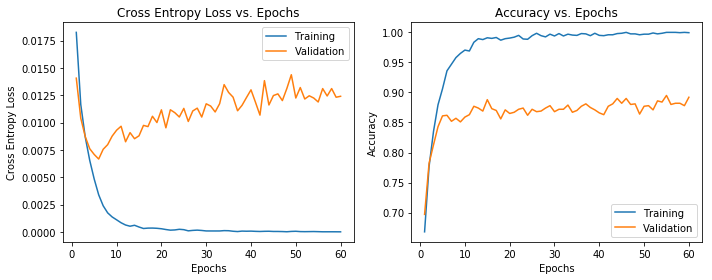

lr = 0.0006829563678601284, reg = 1.9715920946925896e-09.
Best validation accuracy is 0.907. Training time for 60 epochs: 1066.19 sec


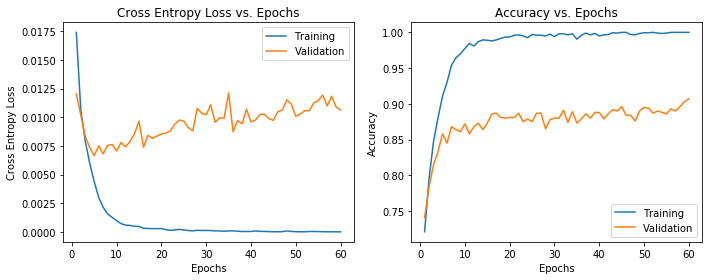

lr = 0.0011045525245197219, reg = 1.5126706970741344e-08.
Best validation accuracy is 0.893. Training time for 60 epochs: 1066.37 sec


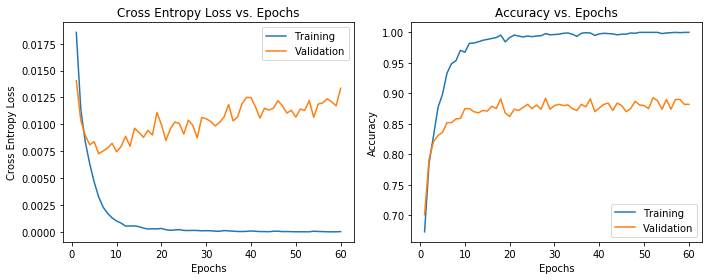

lr = 0.0004360322855995909, reg = 2.796672868570651e-10.
Best validation accuracy is 0.896. Training time for 60 epochs: 1068.61 sec


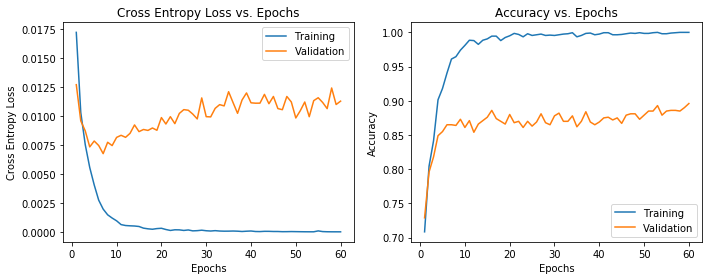

lr = 0.0008613436029298769, reg = 3.418604892906075e-05.
Best validation accuracy is 0.901. Training time for 60 epochs: 1072.83 sec


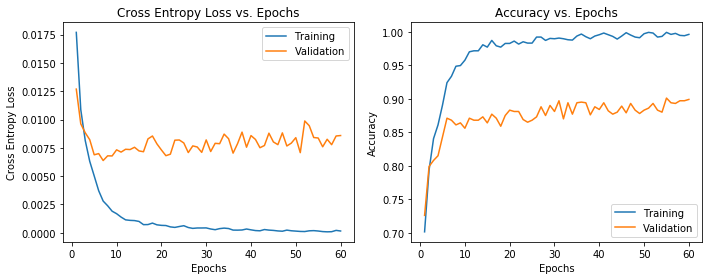

lr = 0.000674670013429449, reg = 3.5905841789736953e-06.
Best validation accuracy is 0.899. Training time for 60 epochs: 1067.47 sec


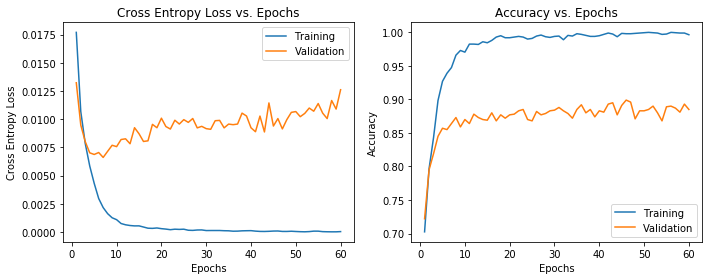

lr = 0.0025277309601765435, reg = 4.6942538070274116e-07.
Best validation accuracy is 0.882. Training time for 60 epochs: 1072.33 sec


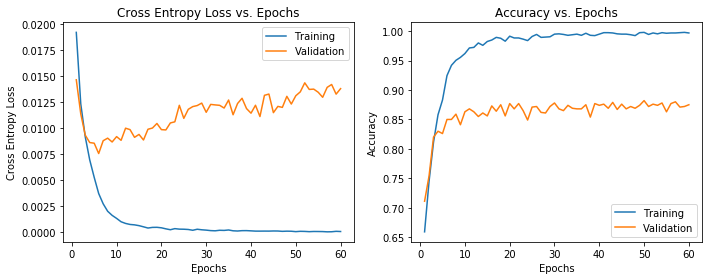

lr = 0.0016198543878535978, reg = 8.794180462539922e-09.
Best validation accuracy is 0.894. Training time for 60 epochs: 1067.06 sec


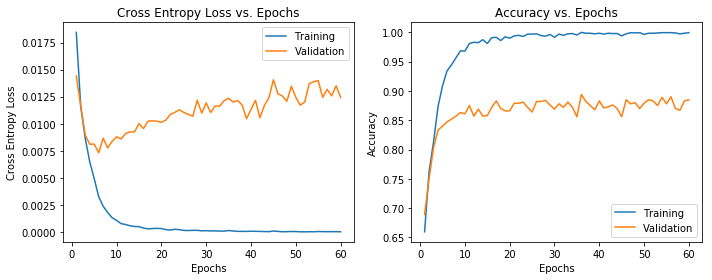

lr = 0.0027438020113796377, reg = 3.220533663939124e-10.
Best validation accuracy is 0.888. Training time for 60 epochs: 1066.58 sec


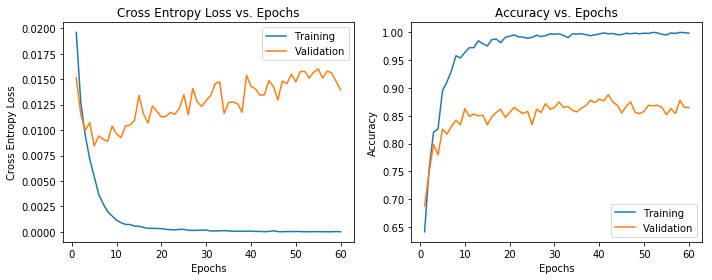

lr = 0.000821417833830257, reg = 1.0160019484085402e-10.
Best validation accuracy is 0.899. Training time for 60 epochs: 1065.51 sec


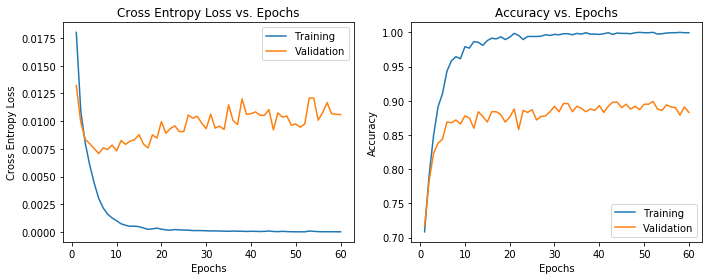

lr = 0.00019245555916826438, reg = 2.003899672159454e-09.
Best validation accuracy is 0.878. Training time for 60 epochs: 1067.11 sec


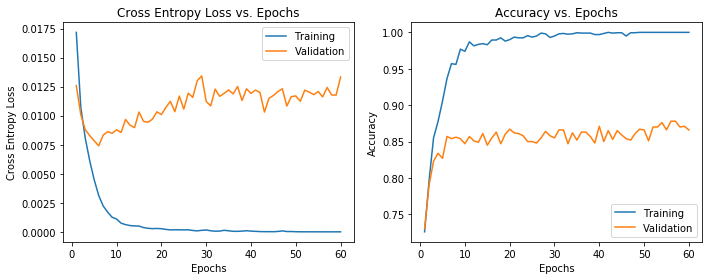

lr = 0.00031701131339051283, reg = 1.1745058552085e-08.
Best validation accuracy is 0.897. Training time for 60 epochs: 1065.94 sec


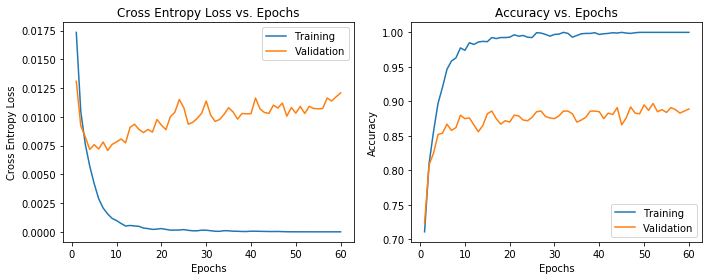

lr = 0.0014069867673871985, reg = 3.5365282915550623e-09.
Best validation accuracy is 0.893. Training time for 60 epochs: 1066.12 sec


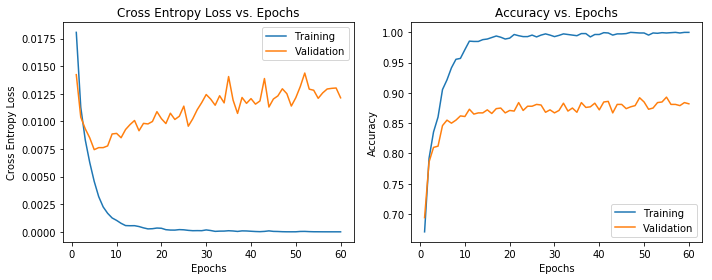

lr = 0.00012144288579402782, reg = 1.3109767276505275e-05.
Best validation accuracy is 0.873. Training time for 60 epochs: 1068.78 sec


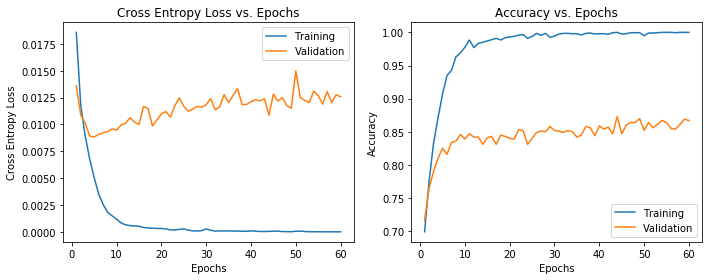

lr = 0.0006585728861284203, reg = 2.052582339812588e-06.
Best validation accuracy is 0.901. Training time for 60 epochs: 1065.45 sec


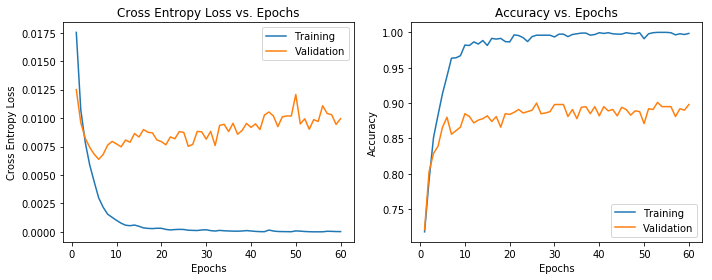

lr = 0.0002535042990776343, reg = 7.411726511783415e-10.
Best validation accuracy is 0.894. Training time for 60 epochs: 1067.13 sec


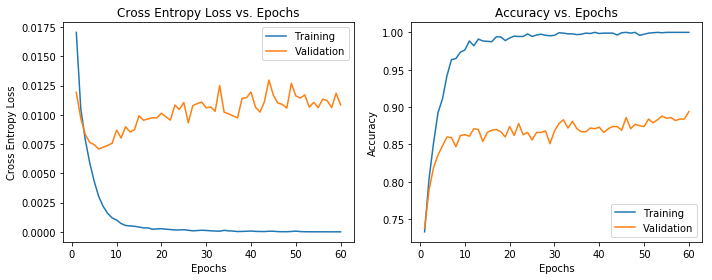

lr = 0.00036930313753496147, reg = 4.372720868170296e-08.
Best validation accuracy is 0.892. Training time for 60 epochs: 1066.18 sec


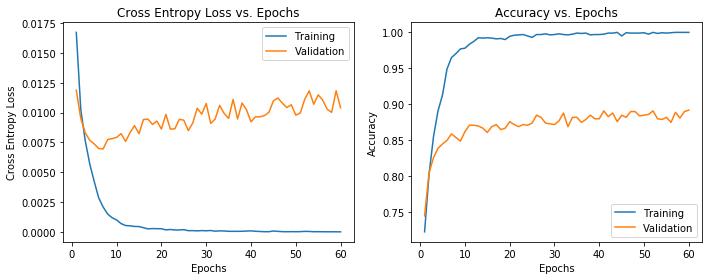

lr = 0.00012896285088952487, reg = 4.774854370388745e-09.
Best validation accuracy is 0.871. Training time for 60 epochs: 1068.34 sec


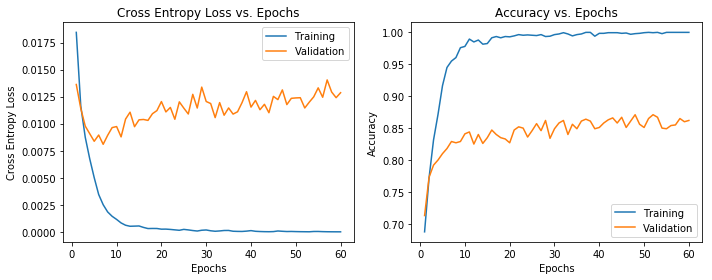

lr = 0.00018044178999455785, reg = 4.833248125142813e-09.
Best validation accuracy is 0.88. Training time for 60 epochs: 1066.58 sec


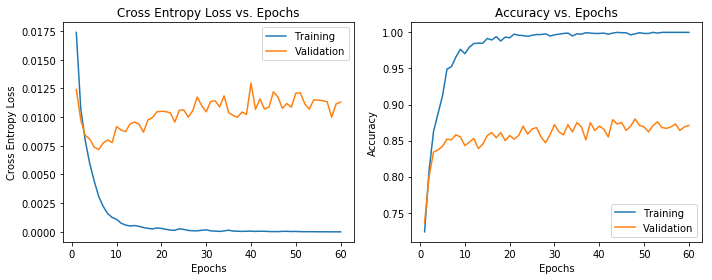

lr = 0.00035597453373368263, reg = 1.7020681420651604e-06.
Best validation accuracy is 0.911. Training time for 60 epochs: 1066.32 sec


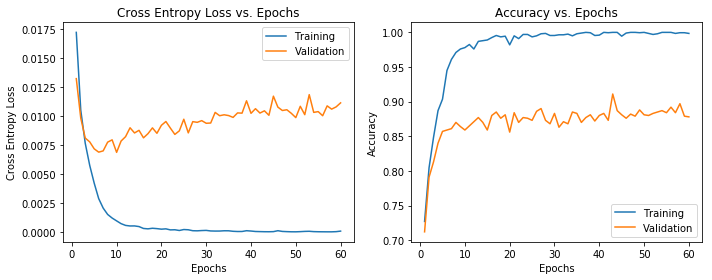

lr = 0.00023227061876066873, reg = 2.7630736418235636e-09.
Best validation accuracy is 0.882. Training time for 60 epochs: 1066.69 sec


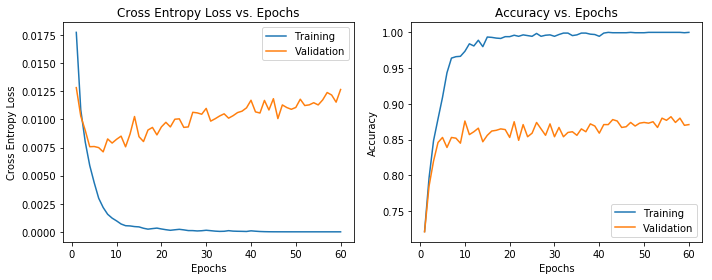

lr = 0.0008995740176354233, reg = 1.3148469405999236e-09.
Best validation accuracy is 0.894. Training time for 60 epochs: 1065.80 sec


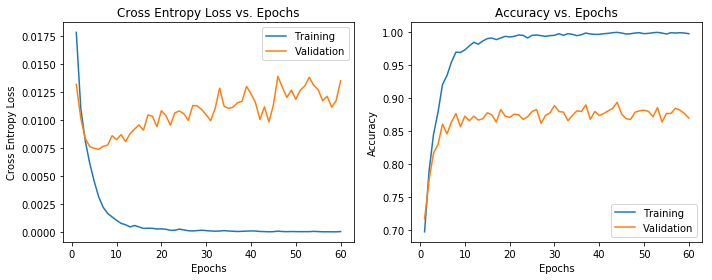

lr = 0.0002607041940129516, reg = 1.268346963364209e-07.
Best validation accuracy is 0.886. Training time for 60 epochs: 1066.23 sec


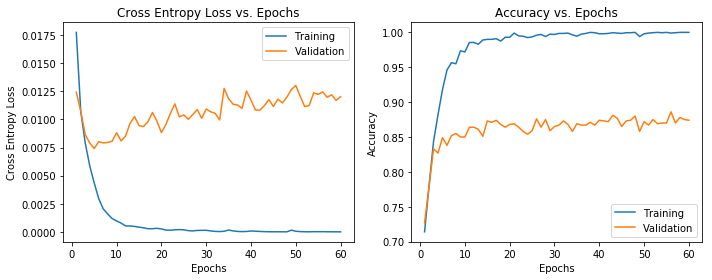

lr = 0.00012076356491036992, reg = 1.4473981365554092e-05.
Best validation accuracy is 0.87. Training time for 60 epochs: 1068.09 sec


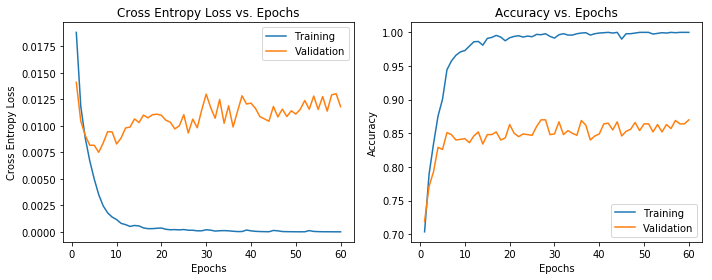

lr = 0.0007055642095887723, reg = 1.1961937486801275e-07.
Best validation accuracy is 0.889. Training time for 60 epochs: 1065.36 sec


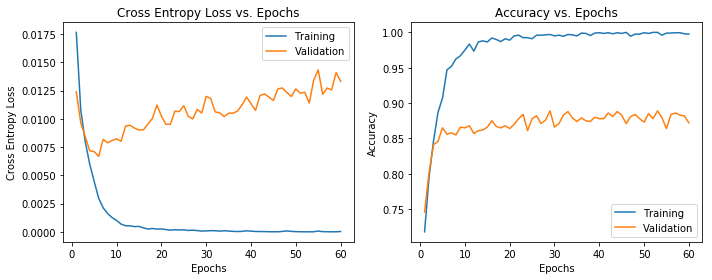

lr = 0.00023222530259810518, reg = 8.775055797476163e-09.
Best validation accuracy is 0.885. Training time for 60 epochs: 1066.35 sec


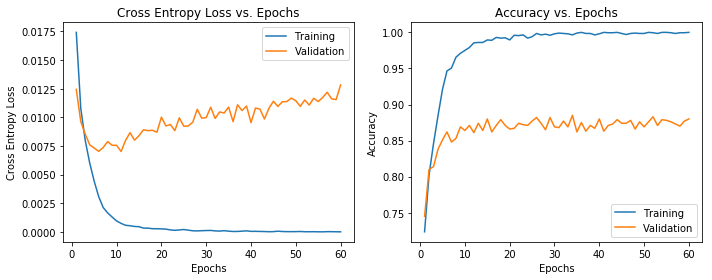

lr = 0.000434494039960778, reg = 1.3553219602189351e-08.
Best validation accuracy is 0.893. Training time for 60 epochs: 1065.48 sec


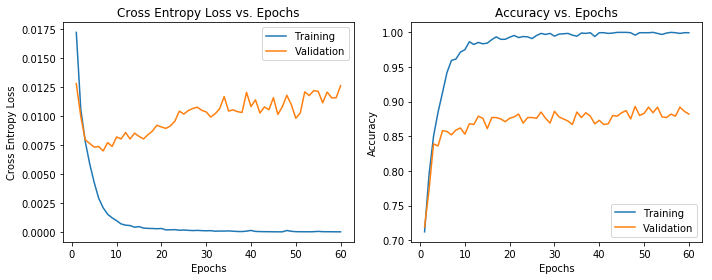

lr = 0.0012346594818947948, reg = 1.9423899110890852e-07.
Best validation accuracy is 0.885. Training time for 60 epochs: 1066.74 sec


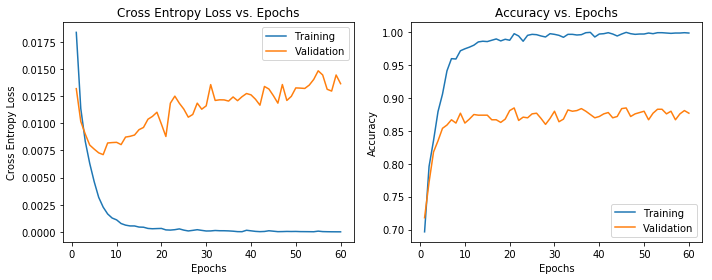

lr = 0.001663366331136048, reg = 5.6690247931177136e-05.
Best validation accuracy is 0.892. Training time for 60 epochs: 1065.96 sec


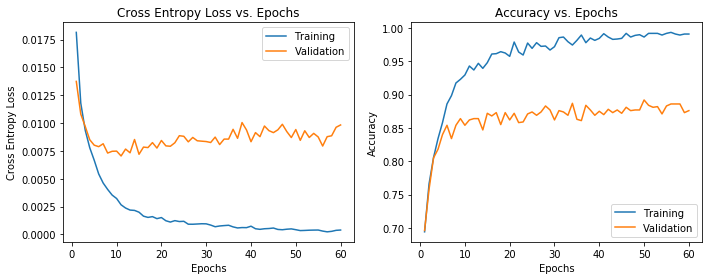

lr = 0.00024231199073315786, reg = 6.230763433039925e-05.
Best validation accuracy is 0.888. Training time for 60 epochs: 1066.98 sec


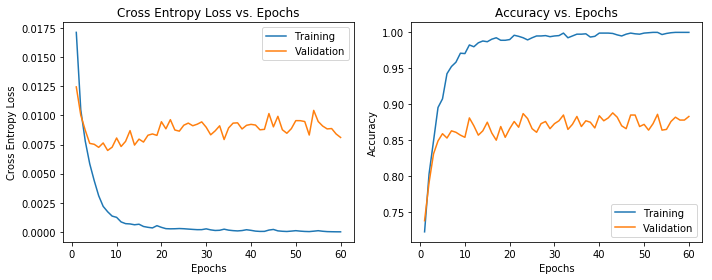

lr = 0.0005355763663254567, reg = 1.3272784929148934e-09.
Best validation accuracy is 0.894. Training time for 60 epochs: 1065.46 sec


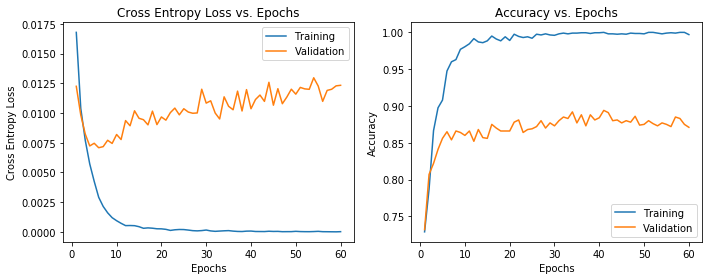

lr = 0.0015036703260416372, reg = 2.68019924811235e-07.
Best validation accuracy is 0.889. Training time for 60 epochs: 1067.19 sec


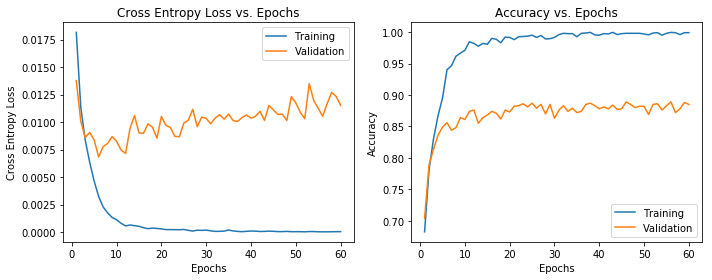

lr = 0.0005806893630058006, reg = 1.1688569310956677e-07.
Best validation accuracy is 0.896. Training time for 60 epochs: 1065.75 sec


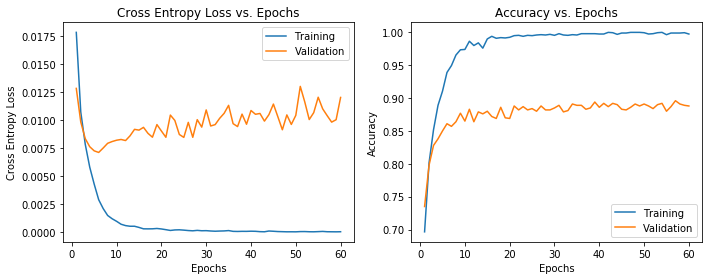

lr = 0.0019415375389550769, reg = 1.4548219883337975e-05.
Best validation accuracy is 0.897. Training time for 60 epochs: 1066.96 sec


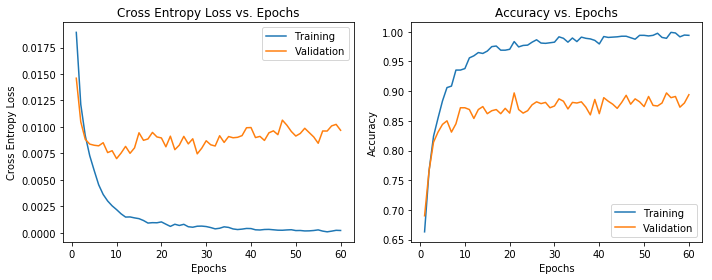

lr = 0.00017239659694925718, reg = 8.704928242368301e-08.
Best validation accuracy is 0.895. Training time for 60 epochs: 1067.54 sec


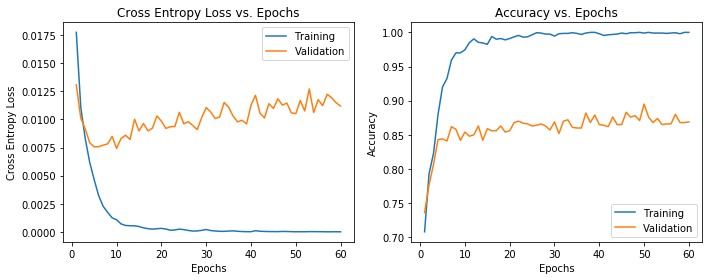

lr = 0.0027811441969746178, reg = 6.125731888201385e-08.
Best validation accuracy is 0.889. Training time for 60 epochs: 1066.96 sec


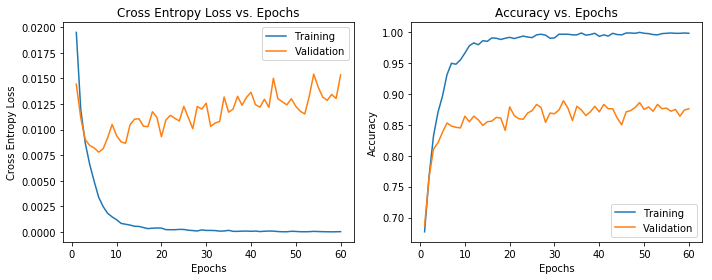

lr = 0.0008598474836561045, reg = 4.413251620996334e-09.
Best validation accuracy is 0.893. Training time for 60 epochs: 1066.06 sec


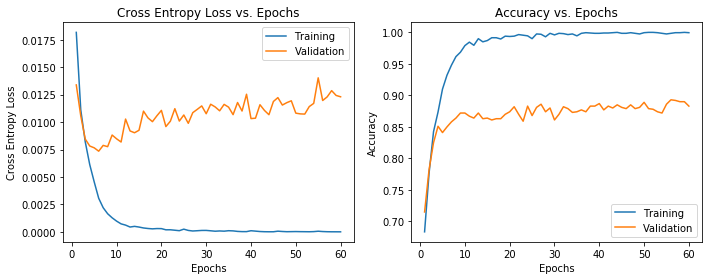

lr = 0.0008292300998774786, reg = 8.967403425584326e-06.
Best validation accuracy is 0.9. Training time for 60 epochs: 1065.94 sec


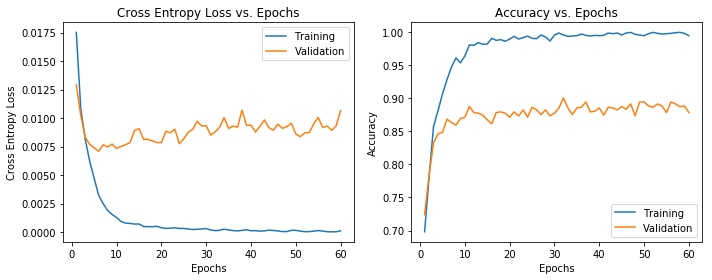

lr = 0.002437513414589876, reg = 1.240947908335962e-05.
Best validation accuracy is 0.89. Training time for 60 epochs: 1067.26 sec


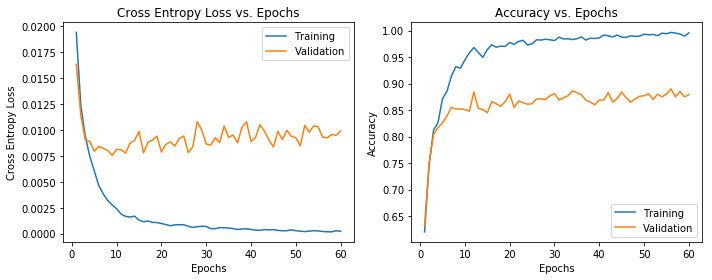

lr = 0.00014190459457975394, reg = 3.0661410975676604e-06.
Best validation accuracy is 0.877. Training time for 60 epochs: 1068.51 sec


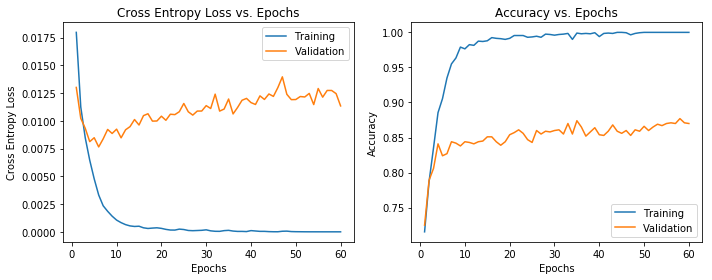

lr = 0.0005180452130046096, reg = 1.7135956424904516e-07.
Best validation accuracy is 0.896. Training time for 60 epochs: 1065.67 sec


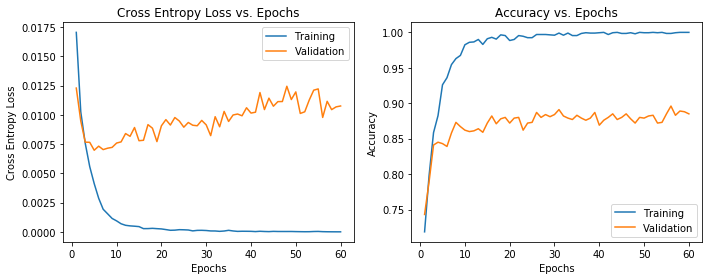

lr = 0.0005774770972900311, reg = 1.5886456575473782e-05.
Best validation accuracy is 0.902. Training time for 60 epochs: 1066.16 sec


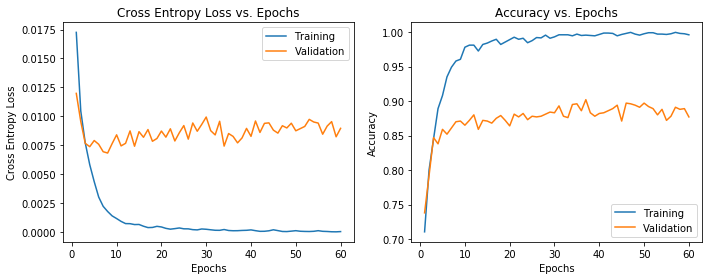

lr = 0.00046606450411209715, reg = 9.667322575091171e-06.
Best validation accuracy is 0.901. Training time for 60 epochs: 1065.74 sec


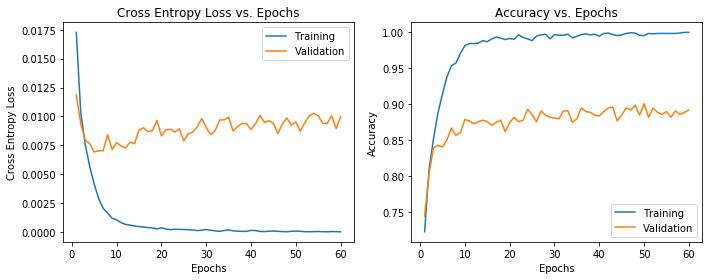

lr = 0.0002588107351667802, reg = 6.617329219439985e-07.
Best validation accuracy is 0.885. Training time for 60 epochs: 1066.54 sec


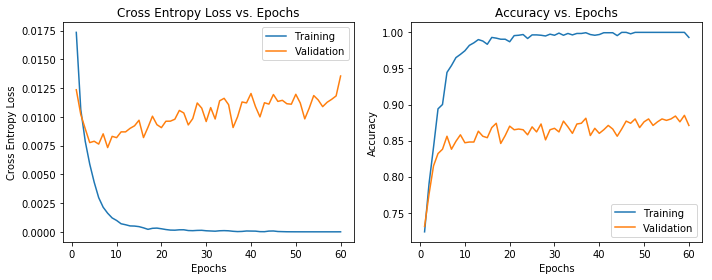

lr = 0.0021039814255822903, reg = 2.5312209244642864e-06.
Best validation accuracy is 0.894. Training time for 60 epochs: 1067.14 sec


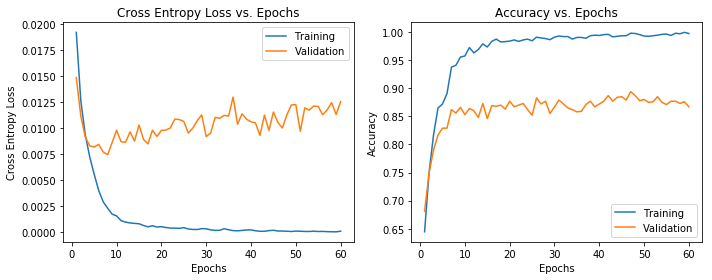

lr = 0.0003021071262503806, reg = 9.721709034987789e-05.
Best validation accuracy is 0.903. Training time for 60 epochs: 1066.44 sec


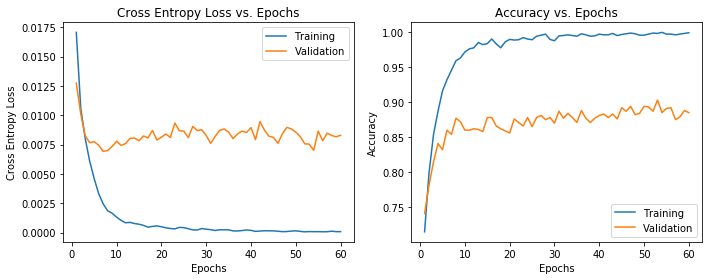

lr = 0.0006847485707457822, reg = 1.408881903650256e-09.
Best validation accuracy is 0.89. Training time for 60 epochs: 1065.60 sec


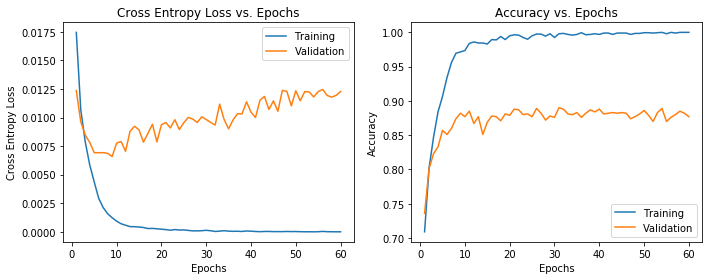

In [12]:
epochs = 60
stat = []

max_count = 50  # Run random 
for count in range(max_count):
    
    reg = 10**random.uniform(-10, -4)
    lr = 10**random.uniform(-4,-2.5)
    
    best_val_acc=0.0
    model = generator_m38().type(gpu_dtype)

    loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

    start = time.time()

    file_name = 'm38-60ep-results/model38'+'_reg='+str('{:.4e}'.format(reg))+'lr='+str('{:.4e}'.format(lr)) \
            +'ep='+str(epochs)+'bestacc.pt'
    best_val_acc, results = train_detailed(model, loss_fn, optimizer, file_name, 
                                                    num_epochs=epochs, verbose=False)

    end = time.time()

    print('lr = {}, reg = {}.'.format(lr, reg))    
    print('Best validation accuracy is {0}. Training time for {1} epochs: {2:.2f} sec'.format(best_val_acc, 
                                                                                              epochs, end-start))
    
    # Save everything so that we can easily retrieve the permutation and model parameters of the best
    # performing models
    stat.append([lr, reg, best_val_acc, file_name])    
    
    # Plot out the accuracies and losses
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(list(range(1,len(np.array(results)[:,2])+1)), np.array(results)[:,2], label='Training')
    plt.plot(list(range(1,len(np.array(results)[:,3])+1)), np.array(results)[:,3], label='Validation')
    plt.title('Cross Entropy Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(list(range(1,len(np.array(results)[:,0])+1)), np.array(results)[:,0], label='Training')
    plt.plot(list(range(1,len(np.array(results)[:,1])+1)), np.array(results)[:,1], label='Validation')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()

    #plt.savefig('sgd_model_plot_batch_norm_hidden_256x256.png')
    plt.show()

## Test Accuracy and Ensemble Averaging

In [13]:
sorted_stat = sorted(stat, key=lambda x: x[2], reverse=True)

for record in sorted_stat:
    print ("Validation Accuracy: {:.3f}   Model:{}".format(record[2],record[3]))

Validation Accuracy: 0.911   Model:m38-60ep-results/model38_reg=1.7021e-06lr=3.5597e-04ep=60bestacc.pt
Validation Accuracy: 0.907   Model:m38-60ep-results/model38_reg=1.9716e-09lr=6.8296e-04ep=60bestacc.pt
Validation Accuracy: 0.903   Model:m38-60ep-results/model38_reg=9.7217e-05lr=3.0211e-04ep=60bestacc.pt
Validation Accuracy: 0.902   Model:m38-60ep-results/model38_reg=1.5886e-05lr=5.7748e-04ep=60bestacc.pt
Validation Accuracy: 0.901   Model:m38-60ep-results/model38_reg=3.4186e-05lr=8.6134e-04ep=60bestacc.pt
Validation Accuracy: 0.901   Model:m38-60ep-results/model38_reg=2.0526e-06lr=6.5857e-04ep=60bestacc.pt
Validation Accuracy: 0.901   Model:m38-60ep-results/model38_reg=9.6673e-06lr=4.6606e-04ep=60bestacc.pt
Validation Accuracy: 0.900   Model:m38-60ep-results/model38_reg=2.1303e-06lr=6.6515e-04ep=60bestacc.pt
Validation Accuracy: 0.900   Model:m38-60ep-results/model38_reg=8.9674e-06lr=8.2923e-04ep=60bestacc.pt
Validation Accuracy: 0.899   Model:m38-60ep-results/model38_reg=3.5906e-0

In [125]:
"""
Validation Accuracy: 0.911   Model:m38-60ep-results/model38_reg=1.7021e-06lr=3.5597e-04ep=60bestacc.pt
Validation Accuracy: 0.907   Model:m38-60ep-results/model38_reg=1.9716e-09lr=6.8296e-04ep=60bestacc.pt
Validation Accuracy: 0.903   Model:m38-60ep-results/model38_reg=9.7217e-05lr=3.0211e-04ep=60bestacc.pt
Validation Accuracy: 0.902   Model:m38-60ep-results/model38_reg=1.5886e-05lr=5.7748e-04ep=60bestacc.pt
Validation Accuracy: 0.901   Model:m38-60ep-results/model38_reg=3.4186e-05lr=8.6134e-04ep=60bestacc.pt
Validation Accuracy: 0.901   Model:m38-60ep-results/model38_reg=2.0526e-06lr=6.5857e-04ep=60bestacc.pt
Validation Accuracy: 0.901   Model:m38-60ep-results/model38_reg=9.6673e-06lr=4.6606e-04ep=60bestacc.pt
Validation Accuracy: 0.900   Model:m38-60ep-results/model38_reg=2.1303e-06lr=6.6515e-04ep=60bestacc.pt
Validation Accuracy: 0.900   Model:m38-60ep-results/model38_reg=8.9674e-06lr=8.2923e-04ep=60bestacc.pt
Validation Accuracy: 0.899   Model:m38-60ep-results/model38_reg=3.5906e-06lr=6.7467e-04ep=60bestacc.pt
"""

files = ['m38-60ep-results/model38_reg=1.7021e-06lr=3.5597e-04ep=60bestacc.pt',
        'm38-60ep-results/model38_reg=1.9716e-09lr=6.8296e-04ep=60bestacc.pt',
        'm38-60ep-results/model38_reg=9.7217e-05lr=3.0211e-04ep=60bestacc.pt',
        'm38-60ep-results/model38_reg=1.5886e-05lr=5.7748e-04ep=60bestacc.pt',
        'm38-60ep-results/model38_reg=3.4186e-05lr=8.6134e-04ep=60bestacc.pt',
        'm38-60ep-results/model38_reg=2.0526e-06lr=6.5857e-04ep=60bestacc.pt',
        'm38-60ep-results/model38_reg=9.6673e-06lr=4.6606e-04ep=60bestacc.pt',
        'm38-60ep-results/model38_reg=2.1303e-06lr=6.6515e-04ep=60bestacc.pt',
        'm38-60ep-results/model38_reg=8.9674e-06lr=8.2923e-04ep=60bestacc.pt',
        'm38-60ep-results/model38_reg=3.5906e-06lr=6.7467e-04ep=60bestacc.pt'
        ]

print ("Size of CFAR10 Test Set: ", len(cifar10_test))

sum_time = 0

for file_name in files:
    best_model = generator_m38().type(gpu_dtype)
    best_model.load_state_dict(torch.load(file_name))
    
    start = time.time()
    acc = check_accuracy(best_model, loader_test, dtype=gpu_dtype)
    end = time.time()
    
    sum_time += (end-start)
    print ("test acc={:.4f} Model={}:".format(acc, file_name))
    
print ("Average inference time of {:.2f}sec for the test set.  ".format(sum_time/len(files)))

Size of CFAR10 Test Set:  10000
test acc=0.8651 Model=m38-60ep-results/model38_reg=1.7021e-06lr=3.5597e-04ep=60bestacc.pt:
test acc=0.8728 Model=m38-60ep-results/model38_reg=1.9716e-09lr=6.8296e-04ep=60bestacc.pt:
test acc=0.8673 Model=m38-60ep-results/model38_reg=9.7217e-05lr=3.0211e-04ep=60bestacc.pt:
test acc=0.8634 Model=m38-60ep-results/model38_reg=1.5886e-05lr=5.7748e-04ep=60bestacc.pt:
test acc=0.8657 Model=m38-60ep-results/model38_reg=3.4186e-05lr=8.6134e-04ep=60bestacc.pt:
test acc=0.8700 Model=m38-60ep-results/model38_reg=2.0526e-06lr=6.5857e-04ep=60bestacc.pt:
test acc=0.8581 Model=m38-60ep-results/model38_reg=9.6673e-06lr=4.6606e-04ep=60bestacc.pt:
test acc=0.8619 Model=m38-60ep-results/model38_reg=2.1303e-06lr=6.6515e-04ep=60bestacc.pt:
test acc=0.8633 Model=m38-60ep-results/model38_reg=8.9674e-06lr=8.2923e-04ep=60bestacc.pt:
test acc=0.8608 Model=m38-60ep-results/model38_reg=3.5906e-06lr=6.7467e-04ep=60bestacc.pt:
Average inference time of 1.60sec for the test set.  


In [128]:
files = ['m38-60ep-results/model38_reg=1.9716e-09lr=6.8296e-04ep=60bestacc.pt',
        'm38-60ep-results/model38_reg=9.7217e-05lr=3.0211e-04ep=60bestacc.pt',
        'm38-60ep-results/model38_reg=1.5886e-05lr=5.7748e-04ep=60bestacc.pt',
        'm38-60ep-results/model38_reg=3.4186e-05lr=8.6134e-04ep=60bestacc.pt',
        'm38-60ep-results/model38_reg=2.0526e-06lr=6.5857e-04ep=60bestacc.pt',
        'm38-60ep-results/model38_reg=9.6673e-06lr=4.6606e-04ep=60bestacc.pt',
        'm38-60ep-results/model38_reg=2.1303e-06lr=6.6515e-04ep=60bestacc.pt',
        'm38-60ep-results/model38_reg=8.9674e-06lr=8.2923e-04ep=60bestacc.pt', # possible 2
        'm38-60ep-results/model38_reg=3.5906e-06lr=6.7467e-04ep=60bestacc.pt'
        ]

models = []
num_models = len(files)

# Create the model ensemble
for n in range(num_models):
    
    model = generator_m38().type(gpu_dtype)
   
    # Load trained parameters into model
    file_name = files[n]
    print ("Loading {} into Model {}".format(file_name, n+1))
    model.load_state_dict(torch.load(file_name))
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)    

    models.append(model)  # Create a list of models

num_correct = 0
num_samples = 0
i = 0

for x, y in loader_test:  # Stanford loader 
# for x, y in testloader:  #PyTorch loader
    x_var = Variable(x.type(gpu_dtype), volatile=True)
    num_samples += x.size()[0]
    scores_sum = torch.zeros(x.size()[0],10).type(gpu_dtype)
    
    for n in range(num_models):
        scores = models[n](x_var)
        scores_sum += scores.data

    y_pred = scores_sum.cpu().max(1)[1]
    num_correct += (y_pred == y).sum()

acc = float(num_correct) / num_samples
print ("Ensemble accuracy is {}".format(acc))


Loading m38-60ep-results/model38_reg=1.9716e-09lr=6.8296e-04ep=60bestacc.pt into Model 1
Loading m38-60ep-results/model38_reg=9.7217e-05lr=3.0211e-04ep=60bestacc.pt into Model 2
Loading m38-60ep-results/model38_reg=1.5886e-05lr=5.7748e-04ep=60bestacc.pt into Model 3
Loading m38-60ep-results/model38_reg=3.4186e-05lr=8.6134e-04ep=60bestacc.pt into Model 4
Loading m38-60ep-results/model38_reg=2.0526e-06lr=6.5857e-04ep=60bestacc.pt into Model 5
Loading m38-60ep-results/model38_reg=9.6673e-06lr=4.6606e-04ep=60bestacc.pt into Model 6
Loading m38-60ep-results/model38_reg=2.1303e-06lr=6.6515e-04ep=60bestacc.pt into Model 7
Loading m38-60ep-results/model38_reg=8.9674e-06lr=8.2923e-04ep=60bestacc.pt into Model 8
Loading m38-60ep-results/model38_reg=3.5906e-06lr=6.7467e-04ep=60bestacc.pt into Model 9
Ensemble accuracy is 0.9027


## Model Metrics

We evaluate parameter number, inference time (GPU vs CPU)

In [139]:
print ("The total number of parameters:", sum([param.nelement() for param in model.parameters()]))

for name, param in model.named_parameters():
    print (name)
    print (param.nelement())

The total number of parameters: 10133066
0.weight
1728
0.bias
64
2.weight
64
2.bias
64
3.weight
36864
3.bias
64
5.weight
64
5.bias
64
6.weight
73728
6.bias
128
8.weight
128
8.bias
128
9.weight
147456
9.bias
128
11.weight
128
11.bias
128
12.weight
294912
12.bias
256
14.weight
256
14.bias
256
15.weight
589824
15.bias
256
17.weight
256
17.bias
256
18.weight
589824
18.bias
256
20.weight
256
20.bias
256
22.weight
8388608
22.bias
512
23.weight
512
23.bias
512
25.weight
5120
25.bias
10


In [143]:
files = [
'm38-60ep-results/model38_reg=1.9716e-09lr=6.8296e-04ep=60bestacc.pt',
]

print ("Size of CFAR10 Test Set: ", len(cifar10_test))

for file_name in files:
    best_model = generator_m38().type(gpu_dtype)
    best_model.load_state_dict(torch.load(file_name))
    
    start = time.time()
    acc = check_accuracy(best_model, loader_test, dtype=gpu_dtype)
    end = time.time()
    
    print ("Model {}:", file_name)
    print ("test accuracy={:.4f} and inference time of {:.2f}sec for the test set.  ".format(acc, end-start))

Size of CFAR10 Test Set:  10000
Model {}: m38-60ep-results/model38_reg=1.9716e-09lr=6.8296e-04ep=60bestacc.pt
test accuracy=0.8730 and inference time of 1.60sec for the test set.  


In [144]:
for file_name in files:
    best_model = generator().type(cpu_dtype)
    best_model.load_state_dict(torch.load(file_name))
    
    start = time.time()
    acc = check_accuracy(best_model, loader_test, dtype=cpu_dtype)
    end = time.time()
    
    print ("Model {}:", file_name)
    print ("test accuracy={:.4f} and inference time of {:.2f}sec for the test set.  ".format(acc, end-start))

Model {}: m38-60ep-results/model38_reg=1.9716e-09lr=6.8296e-04ep=60bestacc.pt
test accuracy=0.8735 and inference time of 88.14sec for the test set.  


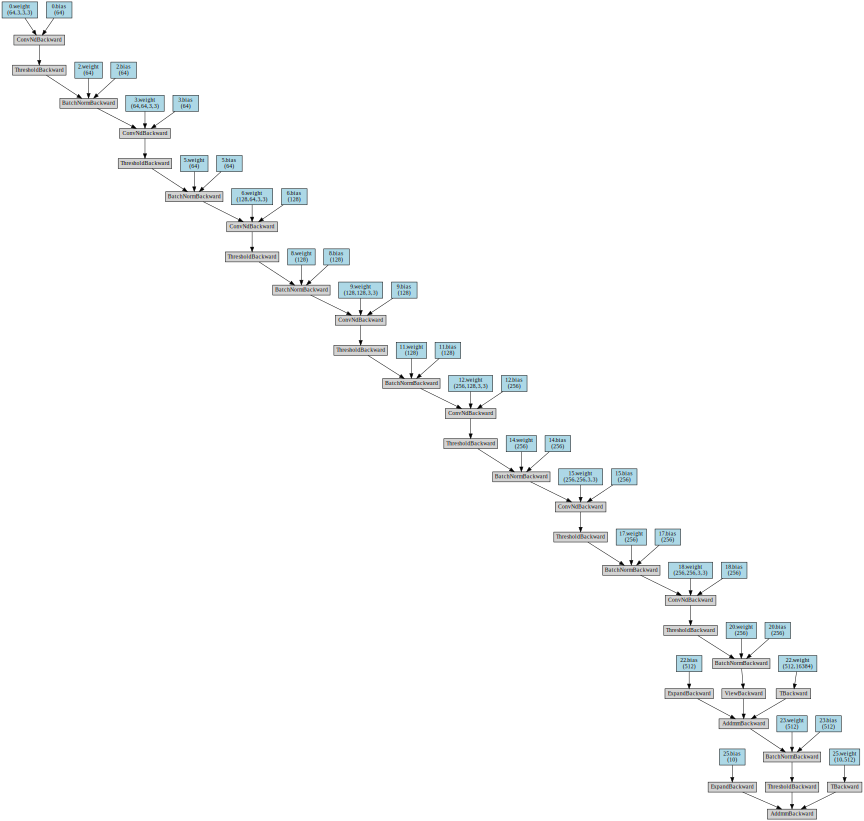

In [4]:
from torchviz import make_dot, make_dot_from_trace

model = generator_m38()

x = torch.randn(64, 3, 32, 32)
x_var = Variable(x) # Construct a PyTorch Variable out of your input data
y = model(x_var)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(y.size()), np.array([64, 10]))

make_dot(y, params=dict(model.named_parameters()))